# Creating a Model for car Price : Random Forest

## Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [ ]:
# Libraries for the Model
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score

# For model classification 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# load the dataset
car_data = pd.read_csv("/cleaned_cardata.csv")
car_data['year'] = car_data['year'].astype('object')
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17966 entries, 0 to 17965
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    17966 non-null  int64  
 1   model         17966 non-null  object 
 2   year          17966 non-null  object 
 3   price         17966 non-null  int64  
 4   transmission  17966 non-null  object 
 5   mileage       17966 non-null  int64  
 6   fuelType      17966 non-null  object 
 7   engineSize    17966 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ MB


In [ ]:
car_data.head()

,Unnamed: 0,model,year,price,transmission,mileage,fuelType,engineSize
0,0,Fiesta,2017,12000,Automatic,15944,Petrol,1.0
1,1,Focus,2018,14000,Manual,9083,Petrol,1.0
2,2,Focus,2017,13000,Manual,12456,Petrol,1.0
3,3,Fiesta,2019,17500,Manual,10460,Petrol,1.5
4,4,Fiesta,2019,16500,Automatic,1482,Petrol,1.0


# Define some helper functions

function for one hot encoding, default is to ohe the car_data

In [ ]:
# Libraries for handling categorical data
from sklearn.preprocessing import OneHotEncoder
def toOHE(df=car_data, catVars=None, numVars=None):
  # categorical variables: catVars
  # Numerical variables: numVars
  # "model", "transmission", "fuelType"
  # 'mileage', 'engineSize', 'year'

  # set default variables
  catVars = ["model", "transmission", "fuelType"] if catVars is None else catVars
  
  numVars = ['mileage', 'engineSize', 'year'] if numVars is None else numVars

  onehot = OneHotEncoder()
  # OneHotEncoding of categorical predictors (Model, transmission, fuelType)
  car_data_cat = df[catVars]
  onehot.fit(car_data_cat)
  car_data_cat_onehot = pd.DataFrame(onehot.transform(car_data_cat).toarray(),
                                    columns = onehot.get_feature_names_out(car_data_cat.columns))
  # Combining Numerical datas with the One Hot encoded features
  car_numeric = df[numVars]
  car_response = df['price']
  car_data_ohe = pd.concat([car_numeric, car_data_cat_onehot, car_response],
                          sort = False, axis = 1).reindex(index=car_numeric.index)
  return car_data_ohe

function for outputting all useful scoring metrics for the model predictions

In [ ]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, accuracy_score
def printMetrics(y_test,y_test_pred):
  print("r2 score (R2) \t:", r2_score(y_test, y_test_pred))
  print("explained variance (R) \t:", explained_variance_score(y_test, y_test_pred))
  print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
  print("accuracy score (R2) \t:", accuracy_score(y_test, y_test_pred))

# Random Forest Model

## Using One Hot Coding to covert categorical data into a more usable format

In [ ]:
#car_data_ohe = toOHE(["model", "transmission", "fuelType"], ['mileage', 'engineSize', 'year'], car_data)
car_data_ohe = toOHE()

In [ ]:
car_data_ohe.head()

,mileage,engineSize,year,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,model_ Escort,model_ Fiesta,model_ Focus,...,model_Focus,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price
0,15944,1.0,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12000
1,9083,1.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,14000
2,12456,1.0,2017,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,13000
3,10460,1.5,2019,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,17500
4,1482,1.0,2019,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16500


## Prediction using the random tree model

### Access if the model is good

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
X = pd.DataFrame(car_data_ohe.drop('price', axis = 1))
y = car_data_ohe['price'].values

clf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, scoring='explained_variance', cv=5)
scores.mean()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.6667286018248536

### Fitting the model

In [ ]:
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
X = pd.DataFrame(car_data_ohe.drop('price', axis = 1))
y = pd.DataFrame(car_data_ohe['price'])

# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (14372, 35) (14372, 1)
Test Set  : (3594, 35) (3594, 1)


In [ ]:
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

<ipython-input-12-231d4f2f1f3a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [ ]:
printMetrics(y_test, y_test_pred)

r2 score (R2) 	: 0.7191728458925126
explained variance (R) 	: 0.7264054051035336
Mean Squared Error (MSE) 	: 6128630.343350028
accuracy score (R2) 	: 0.022537562604340568


## Visualising the results produced by the model

### Looking at feature importance

In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
for index,feature in enumerate(X.columns):
  print(f"feature {index}: {feature}")

feature 0: mileage
feature 1: engineSize
feature 2: year
feature 3: model_ B-MAX
feature 4: model_ C-MAX
feature 5: model_ EcoSport
feature 6: model_ Edge
feature 7: model_ Escort
feature 8: model_ Fiesta
feature 9: model_ Focus
feature 10: model_ Fusion
feature 11: model_ Galaxy
feature 12: model_ Grand C-MAX
feature 13: model_ Grand Tourneo Connect
feature 14: model_ KA
feature 15: model_ Ka+
feature 16: model_ Kuga
feature 17: model_ Mondeo
feature 18: model_ Mustang
feature 19: model_ Puma
feature 20: model_ Ranger
feature 21: model_ S-MAX
feature 22: model_ Streetka
feature 23: model_ Tourneo Connect
feature 24: model_ Tourneo Custom
feature 25: model_ Transit Tourneo
feature 26: model_Focus
feature 27: transmission_Automatic
feature 28: transmission_Manual
feature 29: transmission_Semi-Auto
feature 30: fuelType_Diesel
feature 31: fuelType_Electric
feature 32: fuelType_Hybrid
feature 33: fuelType_Other
feature 34: fuelType_Petrol


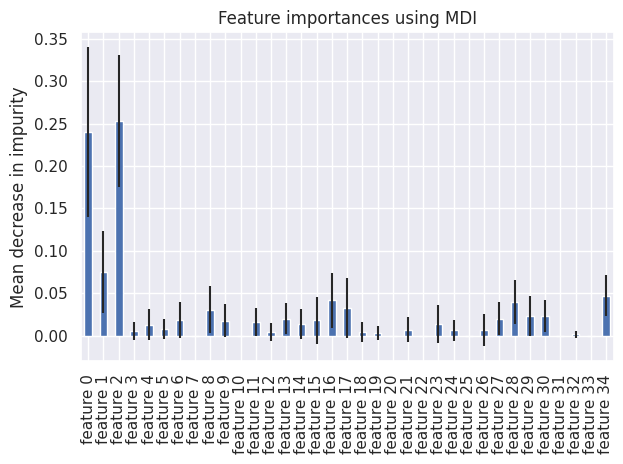

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
forest_importances

feature 0     0.239965
feature 1     0.074951
feature 2     0.253074
feature 3     0.005466
feature 4     0.012961
feature 5     0.007591
feature 6     0.018493
feature 7     0.000000
feature 8     0.030643
feature 9     0.017340
feature 10    0.000000
feature 11    0.015885
feature 12    0.004485
feature 13    0.020014
feature 14    0.013491
feature 15    0.018109
feature 16    0.041480
feature 17    0.032367
feature 18    0.004067
feature 19    0.002874
feature 20    0.000000
feature 21    0.007066
feature 22    0.000000
feature 23    0.013421
feature 24    0.006112
feature 25    0.000000
feature 26    0.006238
feature 27    0.019712
feature 28    0.039644
feature 29    0.023108
feature 30    0.023192
feature 31    0.000000
feature 32    0.001377
feature 33    0.000000
feature 34    0.046871
dtype: float64

### compare the importance of the model of the car

<Axes: >

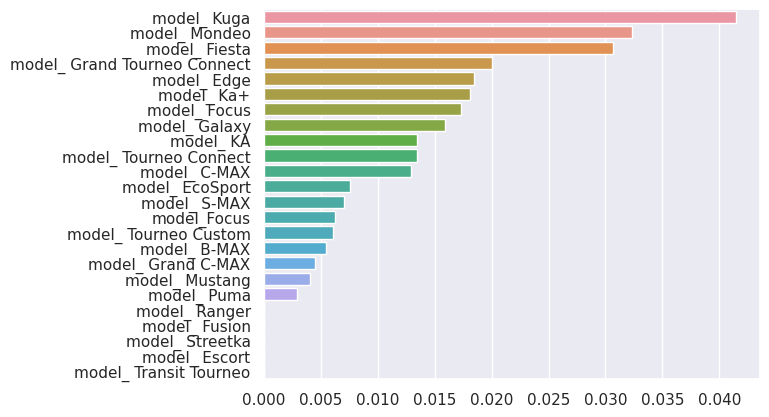

In [ ]:
modelSeries = forest_importances.iloc[3:27]
modelSeries.index = X.columns[3:27]
modelSeries = modelSeries.sort_values(ascending=False)

sb.barplot(x=modelSeries.values, y=modelSeries.index)

compare with the total number of the car models

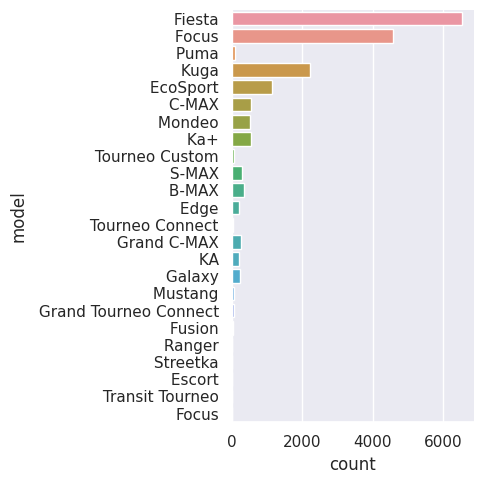

In [ ]:
sb.catplot(y = 'model', data = car_data, kind = "count")

### Visualising predictions by model

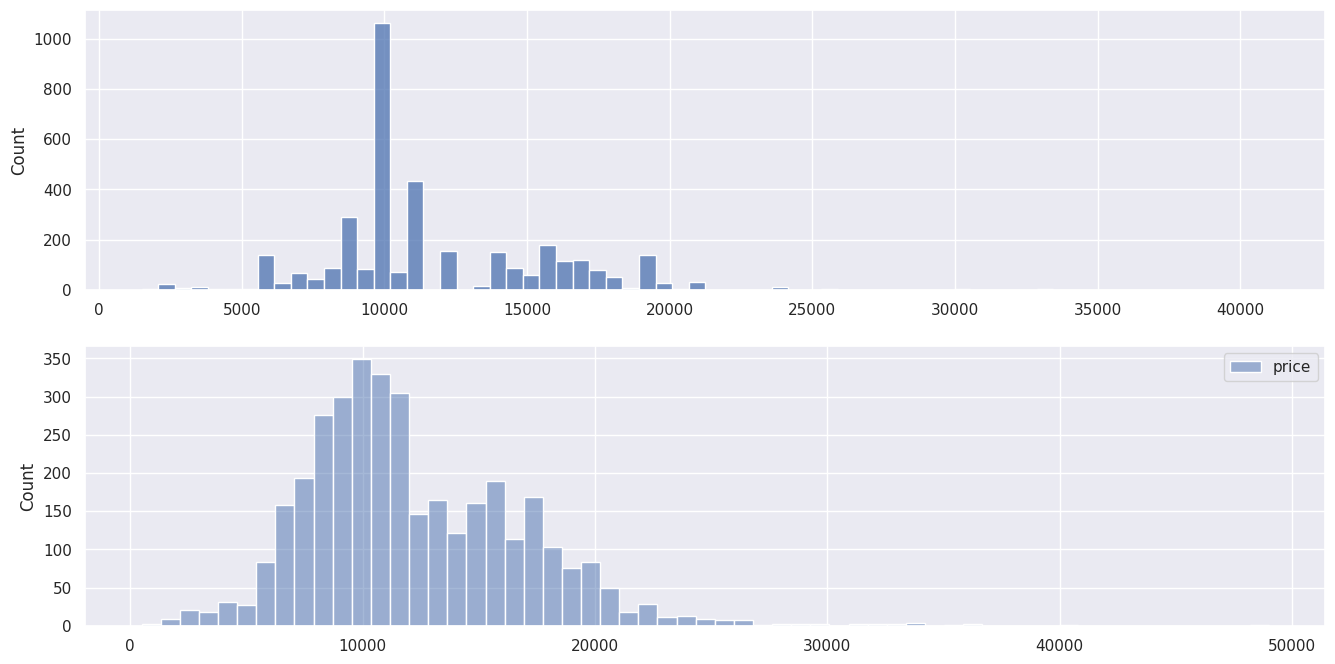

In [ ]:
# Plot the Predictions on a Histplot
f, axes = plt.subplots(2, 1, figsize=(16, 8))
# f = plt.figure(figsize=(16, 8))

# draw histogram of price. 
# prediction top, true value below.
sb.histplot(data = y_test_pred, ax = axes[0])
sb.histplot(data = y_test, ax = axes[1])
plt.show()

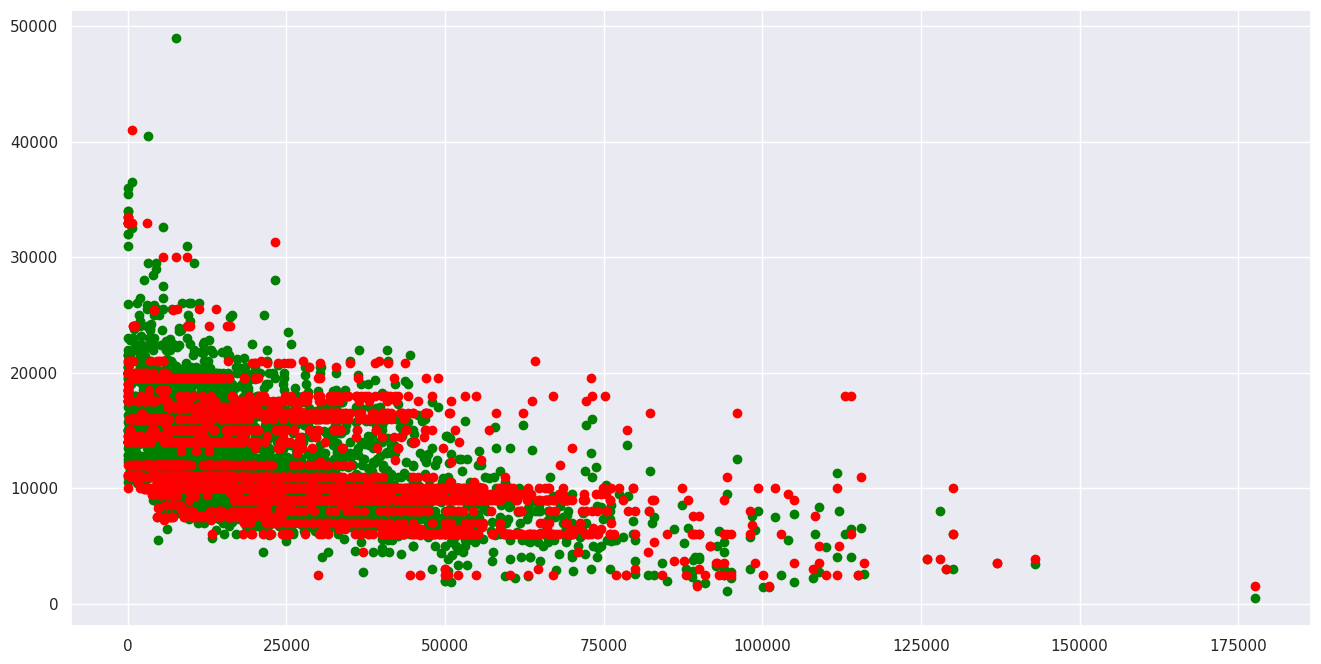

In [ ]:
# Plot the Predictions on a Scatterplot
f = plt.figure(figsize=(16, 8))

# plot price against mileage
# green is true values
# red is predictions
plt.scatter(X_test[['mileage']], y_test, color = "green")
plt.scatter(X_test[['mileage']], y_test_pred, color = "red")
plt.show()

# Using SMOTE to rebalance the car model

In [ ]:
# Libraries for handling categorical data
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [ ]:
X = car_data.drop(['model','Unnamed: 0'],axis = 1)
y = car_data['model']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17966 entries, 0 to 17965
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17966 non-null  object 
 1   price         17966 non-null  int64  
 2   transmission  17966 non-null  object 
 3   mileage       17966 non-null  int64  
 4   fuelType      17966 non-null  object 
 5   engineSize    17966 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 842.3+ KB


In [ ]:
from collections import Counter

In [ ]:
counter = Counter(car_data['model'])
print(counter)

Counter({' Fiesta': 6557, ' Focus': 4588, ' Kuga': 2225, ' EcoSport': 1143, ' C-MAX': 543, ' Ka+': 531, ' Mondeo': 526, ' B-MAX': 355, ' S-MAX': 296, ' Grand C-MAX': 247, ' Galaxy': 228, ' Edge': 208, ' KA': 199, ' Puma': 80, ' Tourneo Custom': 69, ' Grand Tourneo Connect': 59, ' Mustang': 57, ' Tourneo Connect': 33, ' Fusion': 16, ' Streetka': 2, ' Ranger': 1, ' Escort': 1, ' Transit Tourneo': 1, 'Focus': 1})


In [ ]:
ratios = {}
total = np.sum(list(counter.values()))
for key,val in counter.items():
  ratios[key] = round(val/6557*100,2)

print(ratios)

{' Fiesta': 100.0, ' Focus': 69.97, ' Puma': 1.22, ' Kuga': 33.93, ' EcoSport': 17.43, ' C-MAX': 8.28, ' Mondeo': 8.02, ' Ka+': 8.1, ' Tourneo Custom': 1.05, ' S-MAX': 4.51, ' B-MAX': 5.41, ' Edge': 3.17, ' Tourneo Connect': 0.5, ' Grand C-MAX': 3.77, ' KA': 3.03, ' Galaxy': 3.48, ' Mustang': 0.87, ' Grand Tourneo Connect': 0.9, ' Fusion': 0.24, ' Ranger': 0.02, ' Streetka': 0.03, ' Escort': 0.02, ' Transit Tourneo': 0.02, 'Focus': 0.02}


drop the rows for the car models that have few samples

In [ ]:
# df = df.drop(df[(df.score < 50) & (df.score > 20)].index)
# ' Ranger', ' Escort', ' Transit Tourneo', 'Focus'
y = pd.DataFrame(y)

num = 3
total = 0
dropArr = []
for key,item in counter.items():
  if item <= num:
    dropArr.append(key)
    total += item
# print(y[y.model.isin([' Ranger', ' Escort', ' Transit Tourneo', 'Focus'])].index)
toDrop = y[y.model.isin(dropArr)].index
y = y.drop(toDrop)
X = X.drop(toDrop)
print(total)
print(total/sum(counter.values()))

6
0.00033396415451408216


In [ ]:
smote_dict = Counter(y['model'])
print(smote_dict)
for key,item in smote_dict.items():
  if item < 6557: # and item<round(0.69*6557,0):
    smote_dict[key] = 6557 # int(round(0.69*6557,0))
print(smote_dict)

Counter({' Fiesta': 6557, ' Focus': 4588, ' Kuga': 2225, ' EcoSport': 1143, ' C-MAX': 543, ' Ka+': 531, ' Mondeo': 526, ' B-MAX': 355, ' S-MAX': 296, ' Grand C-MAX': 247, ' Galaxy': 228, ' Edge': 208, ' KA': 199, ' Puma': 80, ' Tourneo Custom': 69, ' Grand Tourneo Connect': 59, ' Mustang': 57, ' Tourneo Connect': 33, ' Fusion': 16})
Counter({' Fiesta': 6557, ' Focus': 6557, ' Puma': 6557, ' Kuga': 6557, ' EcoSport': 6557, ' C-MAX': 6557, ' Mondeo': 6557, ' Ka+': 6557, ' Tourneo Custom': 6557, ' S-MAX': 6557, ' B-MAX': 6557, ' Edge': 6557, ' Tourneo Connect': 6557, ' Grand C-MAX': 6557, ' KA': 6557, ' Galaxy': 6557, ' Mustang': 6557, ' Grand Tourneo Connect': 6557, ' Fusion': 6557})


## Using SMOTE to balance the dataset

In [ ]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 2, 4], k_neighbors=2, random_state=0) #sampling_strategy=smote_dict, 
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [ ]:
X_resampled

,year,price,transmission,mileage,fuelType,engineSize
0,2017,12000,Automatic,15944,Petrol,1.0
1,2018,14000,Manual,9083,Petrol,1.0
2,2017,13000,Manual,12456,Petrol,1.0
3,2019,17500,Manual,10460,Petrol,1.5
4,2019,16500,Automatic,1482,Petrol,1.0
...,...,...,...,...,...,...
124578,2019,19619,Manual,26162,Diesel,2.0
124579,2019,29159,Manual,457,Diesel,2.0
124580,2016,18242,Manual,63961,Diesel,2.0
124581,2017,17671,Manual,31764,Diesel,2.0


In [ ]:
y_resampled

,model
0,Fiesta
1,Focus
2,Focus
3,Fiesta
4,Fiesta
...,...
124578,Tourneo Custom
124579,Tourneo Custom
124580,Tourneo Custom
124581,Tourneo Custom


checking the distribution

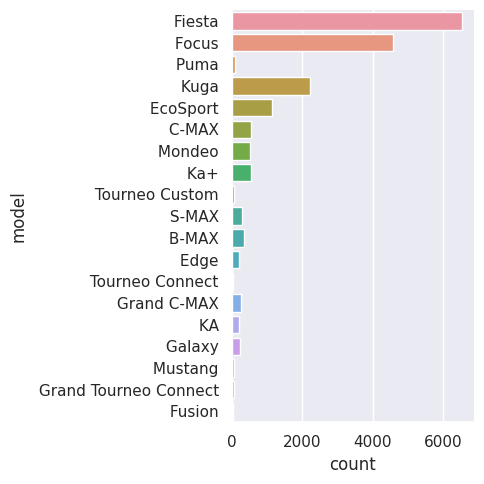

In [ ]:
sb.catplot(y = 'model', data = y, kind = "count")

<Figure size 1600x800 with 0 Axes>

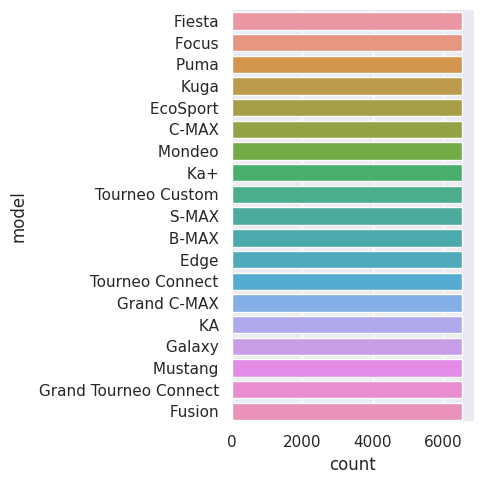

In [ ]:
# Plot the Predictions on a Histplot
f = plt.figure(figsize=(16, 8))
# f = plt.figure(figsize=(16, 8))

# visualize the data 
sb.catplot(y = 'model', data = y_resampled, kind = "count")
plt.show()

## Train model on the rebalanced dataset

In [ ]:
# year	price	transmission	mileage	fuelType	engineSize
# Libraries for handling categorical data
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
# OneHotEncoding of categorical predictors (Model , year, transmission, fuelType)
car_data_cat = pd.concat([X_resampled[["transmission", "fuelType"]], y_resampled['model']],
                        sort = False, axis = 1).reindex(index=y_resampled['model'].index)
                        
onehot.fit(car_data_cat)
car_data_cat_onehot = pd.DataFrame(onehot.transform(car_data_cat).toarray(),
                                  columns = onehot.get_feature_names_out(car_data_cat.columns))

# Combining Numerical datas with the One Hot encoded features
car_numeric = X_resampled[['mileage', 'engineSize', 'year']]
car_response = X_resampled['price']
car_data_ohe = pd.concat([car_numeric, car_data_cat_onehot, car_response],
                        sort = False, axis = 1).reindex(index=car_numeric.index)

car_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124583 entries, 0 to 124582
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   mileage                       124583 non-null  int64  
 1   engineSize                    124583 non-null  float64
 2   year                          124583 non-null  object 
 3   transmission_Automatic        124583 non-null  float64
 4   transmission_Manual           124583 non-null  float64
 5   transmission_Semi-Auto        124583 non-null  float64
 6   fuelType_Diesel               124583 non-null  float64
 7   fuelType_Electric             124583 non-null  float64
 8   fuelType_Hybrid               124583 non-null  float64
 9   fuelType_Other                124583 non-null  float64
 10  fuelType_Petrol               124583 non-null  float64
 11  model_ B-MAX                  124583 non-null  float64
 12  model_ C-MAX                  124583 non-nul

In [ ]:
X_resampled = car_data_ohe.drop('price',axis = 1)
y_resampled = car_data_ohe['price']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, random_state=0)
#clf.fit(X,Y)
# Import the required function from sklearn
from sklearn.model_selection import train_test_split

# Extract Response and Predictors
# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state=0)


In [ ]:

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)
clf.fit(X_train, y_train)

Train Set : (99666, 30) (99666,)
Test Set  : (24917, 30) (24917,)


RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

In [ ]:
y_test_pred = clf.predict(X_test)

printMetrics(y_test,y_test_pred)

r2 score (R2) 	: 0.4846783846836763
explained variance (R) 	: 0.48884994149847605
Mean Squared Error (MSE) 	: 32372637.378978208
accuracy score (R2) 	: 0.022916081390215514
